In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Overview
1. load the data from df_train.csv
2. Extract the numerical features from the data (df_numeric)
3. Find the optimal number of clusters using the elbow method 
4. Apply kMeans and compare the shilouette score
   - df_numeric
   - standardized df_numeric
   - scaled df_numeric
5. Analyze the best model

 ## Limitation
 I use all numerical features, and standardize or/and scale them.
 
 If I select the features to train or select the feature to standardize or scale, the result might be different.

This is the next step after methodology submission assignment.

## 1. load the data

In [2]:
from utils import get_df_description

# load df
df = pd.read_csv('../datasets/df_sample_5000.csv')
print(df.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df, description_json_df)
df_description

(5000, 23)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
2,fo_order_id,object,0,df_orders,FK
3,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
4,fo_order_status,object,0,df_orders,
5,fo_order_purchase_timestamp,object,0,df_orders,
6,fo_order_approved_at,object,0,df_orders,
7,fo_order_delivered_carrier_date,object,0,df_orders,
8,fo_order_delivered_customer_date,object,0,df_orders,
9,fo_order_estimated_delivery_date,object,0,df_orders,


## 2. Prepare df_numeric

In [3]:
## Selecting numeric columns
df_numeric = df.select_dtypes(include=['number']).dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix']) ## qualitative
print(df_numeric.shape)
df_numeric.head()

(4843, 10)


,repeater,recency,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,customer_in_sao_paulo
0,0,376,2,403.81,1,1,-10.0,4.0,0.0,0
1,0,351,1,95.11,1,1,0.0,4.0,0.0,0
2,0,336,1,75.42,1,1,-12.0,4.0,0.0,0
3,0,477,1,148.06,1,1,-12.0,3.0,0.0,0
4,0,252,0,58.62,1,1,-9.0,3.0,0.0,1


## 3. Find the optimal number of clusters using the elbow method

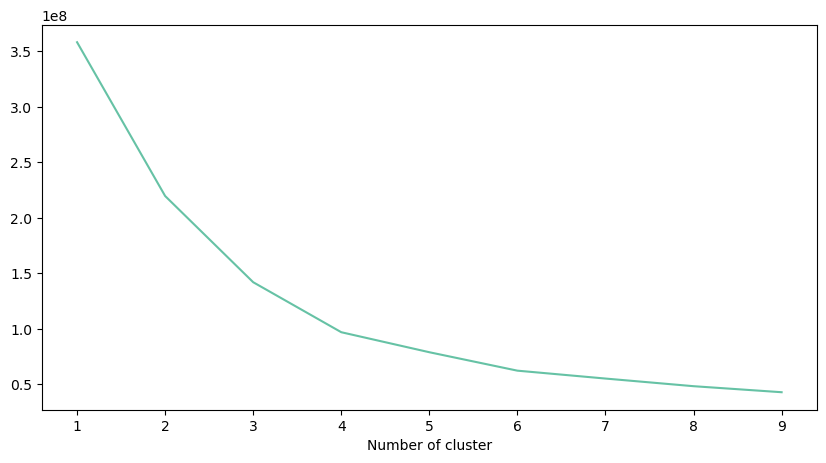

In [4]:
from sklearn.cluster import KMeans

## First of all, we need to know the optimal number of clusters
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42, n_init=10).fit(df_numeric)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

The plot shows that the optimal number of cluster for original data is 3-6.

In the step 4, I test the range 2-10 for the number of clusters, and find the optimal number that has the highest shilouette score.

## 4. Apply kMeans and compare the shilouette score
 - df_numeric
 - standardized df_numeric
 - scaled df_numeric

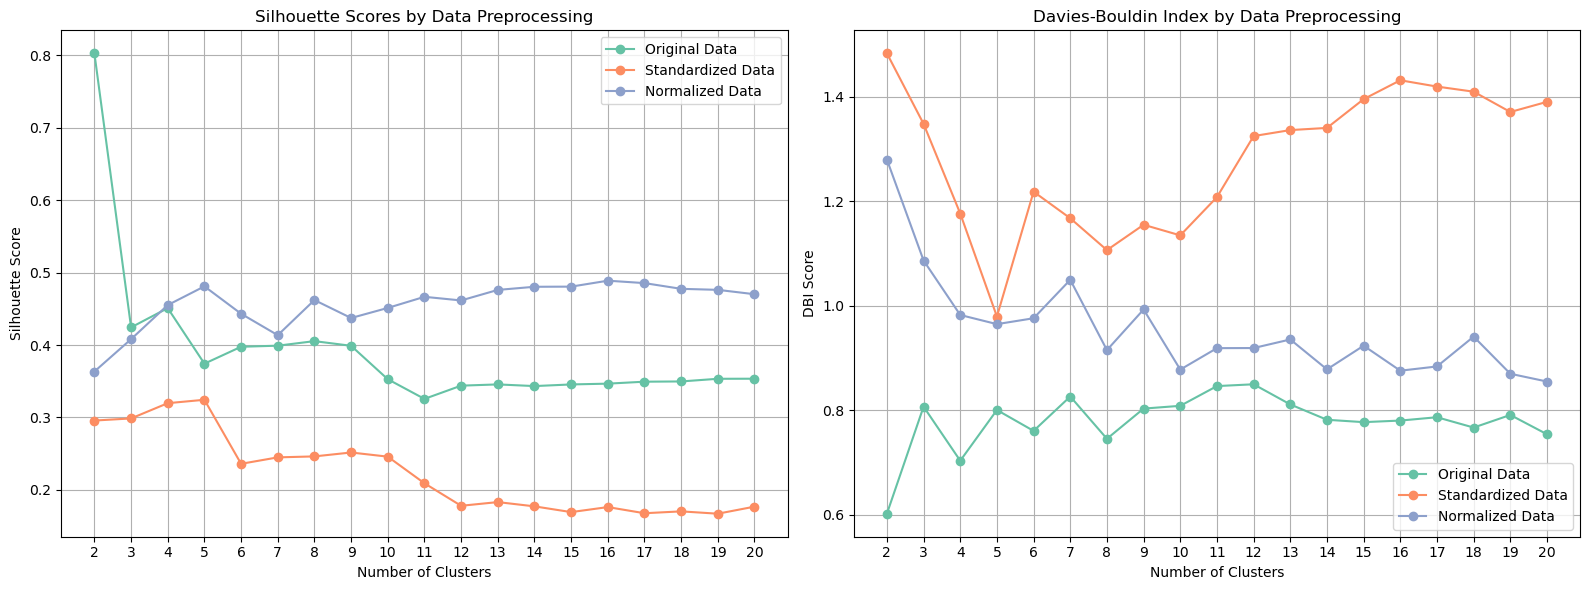

In [5]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from utils import standardize, normalize

def find_optimal_clusters(data, max_clusters=20):
  silhouette_scores = []
  dbi_scores = []
  for n_clusters in range(2, max_clusters + 1):  # Start from 2 since 1 cluster is not meaningful
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, labels))
    dbi_scores.append(davies_bouldin_score(data, labels))

  return silhouette_scores, dbi_scores

def plot_scores(results, max_clusters=20):
  fig, axes = plt.subplots(1, 2, figsize=(16, 6))
  cluster_range = range(2, max_clusters + 1)
  data_types = ['Original Data', 'Standardized Data', 'Normalized Data']

  for idx, (data_type, scores) in enumerate(results.items()):
    axes[0].plot(cluster_range, scores['Silhouette'], marker='o', linestyle='-', label=data_type)
    axes[1].plot(cluster_range, scores['DBI'], marker='o', linestyle='-',  label=data_type)

  axes[0].set_title('Silhouette Scores by Data Preprocessing')
  axes[0].set_xlabel('Number of Clusters')
  axes[0].set_ylabel('Silhouette Score')
  axes[0].set_xticks(cluster_range)
  axes[0].legend()
  axes[0].grid(True)

  axes[1].set_title('Davies-Bouldin Index by Data Preprocessing')
  axes[1].set_xlabel('Number of Clusters')
  axes[1].set_ylabel('DBI Score')
  axes[1].set_xticks(cluster_range)
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

results = {}

# Process each type of data
for data_type, func in [('Original Data', lambda x: x),
                        ('Standardized Data', standardize),
                        ('Normalized Data', normalize)]:
  processed_data = func(df_numeric)
  silhouette, dbi = find_optimal_clusters(processed_data)
  results[data_type] = {'Silhouette': silhouette, 'DBI': dbi}

plot_scores(results)

In [6]:
results

{'Original Data': {'Silhouette': [0.802708621519655,
   0.42435005910182133,
   0.45095340646633736,
   0.3742385576162131,
   0.3976045216286462,
   0.3990693360121486,
   0.4053631625939704,
   0.3989294778620255,
   0.35276385537347144,
   0.3256101661015244,
   0.34389618035740693,
   0.3456064431378786,
   0.34331148014723506,
   0.34556616576402976,
   0.3466653788290682,
   0.3493647210160842,
   0.3497042671730839,
   0.35337317495924514,
   0.3534835425024338],
  'DBI': [0.6017540010342564,
   0.8067617914391398,
   0.7032281481687288,
   0.8003629822084631,
   0.7603579356147264,
   0.8262032232078484,
   0.7452174120171338,
   0.803046011053964,
   0.8083434613152617,
   0.8461582624678582,
   0.8496056228837374,
   0.8110011695901407,
   0.7816416541916363,
   0.7770891183790739,
   0.7801201951466468,
   0.7864987523874298,
   0.7667133185891696,
   0.7908698264113421,
   0.7538951829071238]},
 'Standardized Data': {'Silhouette': [0.29572069012216,
   0.2986306756294311,
 

## 5. Analyze the best model

In [7]:
from utils import get_comparison_df

## train df_ umeric again.
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_numeric)

## get centroids
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=df_numeric.columns)

centroids_comparison_df = get_comparison_df(df_numeric, centroids_df)
centroids_comparison_df

,Feature,cl1_centroid,cl2_centroid,Data Mean,Data Median
0,repeater,0.010638,0.029690,0.029321,0.00
1,recency,268.989362,284.959992,284.650010,267.00
2,rfm_score,2.361702,0.494209,0.530456,0.00
3,fo_payment_value,1358.943511,134.037728,157.812484,104.37
4,fo_is_daytime,0.978723,0.901032,0.902540,1.00
5,fo_is_weekday,0.797872,0.770478,0.771010,1.00
6,fo_delivery_delay_days,-11.212766,-11.946726,-11.932480,-12.00
7,fo_review_score_mean,3.994681,4.184039,4.180363,5.00
8,fo_voucher_payment_value,30.999362,2.807953,3.355133,0.00
9,customer_in_sao_paulo,0.287234,0.418404,0.415858,0.00


**Interpretation**
- The comparison about monetary and fo_payment_value suggests the the customers in cluster 2 spend more money than cluster 1.
- Regarding the fo_voucher_payment_value, customers in cluster 2 use more voucher than cluster 1.
- We can use analyze more deeply for each cluster or features.


### Visualization

In [8]:
df.columns

Index(['customer_unique_id', 'repeater', 'fo_order_id', 'fo_customer_id',
       'fo_order_status', 'fo_order_purchase_timestamp',
       'fo_order_approved_at', 'fo_order_delivered_carrier_date',
       'fo_order_delivered_customer_date', 'fo_order_estimated_delivery_date',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'recency', 'rfm_score', 'fo_payment_value', 'fo_is_daytime',
       'fo_is_weekday', 'fo_delivery_delay_days', 'fo_review_score_mean',
       'fo_voucher_payment_value', 'fo_product_category_name',
       'customer_in_sao_paulo'],
      dtype='object')

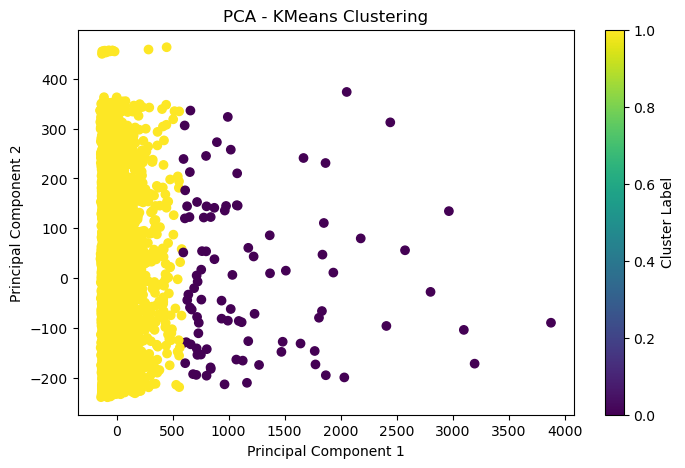

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_numeric)

plt.figure(figsize=(8, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('PCA - KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

**Interpretation**
- Cluster Separation: The visualization shows two distinct clusters indicated by different colors, suggesting that K-means identified two separate groups.

- Cluster Density: The yellow cluster consists of fewer data points, while the purple cluster includes a larger number of points, indicating possible variations within each cluster.

- Principal Components: The horizontal axis (Principal Component 1) captures the most significant variance in the data, and the vertical axis (Principal Component 2) captures the second most. The scale of the first principal component is notably larger, indicating a significant variance in one of the dataset's features.

- Outliers: There are several data points within the yellow cluster that are positioned far from the main group, which could be considered outliers or noise.

- Overlap: While the clusters are reasonably well-separated, there is some overlap, with a few points from the yellow cluster interspersed within the purple cluster.

This PCA visualization demonstrates that K-means clustering has distinguished two reasonably distinct groups with some degree of overlap. The large scale of the first principal component suggests a strong contribution from a particular feature to the data's variability, which should be interpreted in the context of the dataset. Additional dimensionality reduction techniques such as t-SNE might be employed to explore the subtle structures and relationships within the clusters in more detail.

| Model | Preprocessed Data | Number of Clusters | Silhouette Score | DBI Score | Settings |
| --- | --- | --- | --- | --- | --- |
| K-means | Original Data | 2 | 0.80 | 0.60 | |
| DBSCAN | Normalized Data | 13 | 0.53 | 1.05 | eps=0.6 |
| Agglomerative | Original Data | 3 | 0.83 | 0.09 | single linkage, euclidean distance metric |